## 라이브러리 import
---

In [2]:
import os
import sentencepiece as spm
from konlpy.tag import Mecab
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np

import urllib.request
import pandas as pd

import csv
from sklearn.model_selection import train_test_split

%matplotlib inline

## 데이터 불러오기
---

In [3]:
# train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
# test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

naver_df = pd.read_table('ratings.txt')
raw_len = len(naver_df)
naver_df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


## 데이터 전처리
---

결측치 제거

In [4]:
naver_df.isnull().sum()

id          0
document    8
label       0
dtype: int64

In [5]:
naver_df = naver_df.dropna(how='any')
print(naver_df.isnull().sum)

<bound method NDFrame._add_numeric_operations.<locals>.sum of            id  document  label
0       False     False  False
1       False     False  False
2       False     False  False
3       False     False  False
4       False     False  False
...       ...       ...    ...
199995  False     False  False
199996  False     False  False
199997  False     False  False
199998  False     False  False
199999  False     False  False

[199992 rows x 3 columns]>


중복 제거

In [6]:
corpus = naver_df.drop_duplicates(['document'])  

In [7]:
print('전처리 전 데이터 개수 :', raw_len)
print('전처리 후 데이터 개수 :', len(corpus)) 

전처리 전 데이터 개수 : 200000
전처리 후 데이터 개수 : 194543


In [8]:
corpus.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


### 데이터 분석
---

In [9]:
review = corpus['document']
review.head()

0                                  어릴때보고 지금다시봐도 재밌어요ㅋㅋ
1    디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...
2                 폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.
3    와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...
4                          안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.
Name: document, dtype: object

문장의 최단 길이: 1
문장의 최장 길이: 142
문장의 평균 길이: 36


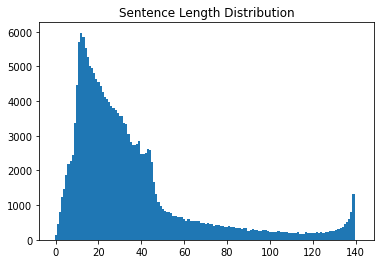

In [10]:
min_len = 999
max_len = 0
sum_len = 0

for sen in review:
    length = len(sen)
    if min_len > length: 
        min_len = length
        
    if max_len < length: 
        max_len = length
    
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(review))

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in review:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [11]:
def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            print(count)
            count += 1
            if count > 10: return 
            
def count_sentencenum_by_length(init, end):
    count = 0

    for sen_l in range(init, end):
        count += sentence_length[sen_l]
    return count
        

In [12]:
check_sentence_with_length(review, 135)

내가 남자라그런가 이거 겁나 긴장감있고 흥미진진하던데..ㄷㄷ 나만그런가워낙에 격투씬을 좋아해서.ㅋㅋㅋ 그냥 아무생각없이 집에서 스마트티비로 봐서 재밌었나봄 이거 뭔영화인지도 모르고 암살에 나온 이정재 있길래 걍봄 ㅋㅋ 하여튼 너무 재밌게 봤음
0
줄리아 로버츠의 웃음은 정말 보는 사람을 기쁘게 해준다. 웃음 하나로 기쁨과 슬픔을 표현할 수 있는 배우..전통을 깨고 여성의 새로운 삶을 살으라고 영화는 보여주는 데 영화에서는 전통을 완전히 벗어나야 한다는 것만을 강조하는 것 같아 아쉽다.
1
평점 왜 이렇게 낮아요??? 영화 대박인데...진짜....ㅋㅋㅋ 와.. 어떻게 이런상상을 해서 이런 영화를... 대박대박.. ㅠ 생각지못한 반전.. 처음엔 반신반의하면서 봤는데.. 최고내요...ㄷㄷㄷ 근데 금발 여주는 중반에 좀 짜증나긴했음ㅋ
2
큰 기대 안하고 띄엄띄엄 보다가 집중해서 봤네요!! 저는 잘봤습니다. 액션도 뛰어나고 아슬아슬한 장면들을 극복해 가는게 나름 잼있었어요!! 마지막에 여자 박사가 살았는지 죽었는지가 안나와서 좀 아쉽네요..그래도 딸은 살렸으니 다행스럽다는 ㅎㅎ
3
누군가는 잃고, 누군가는 벌고, 또 누군가는 죽는 게임. 그리고 끊임없이 반복되는 삶과 기억의 굴레. 하지만 시작할 때부터 영화는 이미 심각했고, 지루했다. 다 본 후 생각해보니 그럴 수밖에 없었겠다 싶다. 넓고 얕은 재미, 길고 깊은 여운.
4
영화내용은 사실별거 없지만 보고나면 생각을 많이하게 되는 영화임. 재미있기도 하고, 결론은 무엇이냐 하면 빨갱이들이 아무것도 모르는 사람들 선동해서 비참한 결과를 낳게 한다는 내용임. 복수심에 불타는 이북출신들도 나오는데 다 역사적인 사실임.
5
고등학교때 보고 지금에서 생각난 영화 참~그땐 눈물 콧물 흘리면서 봤는데짐 보면 나올라나.. 하긴 세월이 많이 흘렀지 아마 짐 시대하곤 스토리자체가 뻔하니깐 하지만 지금도 잊혀지지않는장면은 주인공이 공부하는장면과하늘도 갈라놓지 못한 그들의사랑
6
오스카는 흔히 볼수있는 아들이자 장난끼 많은 오빠 그리고 항상

In [13]:
# sentence_length[135]
    
print(f'길이 135 이상의 문장수: {count_sentencenum_by_length(135, 142)}')

길이 135 이상의 문장수: 3686


문장확인

In [14]:
check_sentence_with_length(review, 10)

내용이너무좋아요.ㅎ
0
뀰잼이다뀰잼이라구여
1
13살이엇냐?...
2
알파치노 연기때문에
3
이물감. 시 같았다
4
매력적인 영화...
5
이거 재밌는데...
6
.겁쟁이페달보고싶다
7
한국 영화치고 좋다
8
정말 멋진 결말!ㅎ
9
너무 잘 봣어요..
10


In [15]:
check_sentence_with_length(review, 1)

굿
0
핡
1
휴
2
시
3
ㅋ
4
ㅇ
5
‥
6
O
7
갑
8
ㅎ
9
.
10


In [16]:
   
print(f'길이 10 이하의 문장수: {count_sentencenum_by_length(0, 10)}')

길이 10 이하의 문장수: 16226


### 문장 길이 선정
---

In [17]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))
    
def above_threshold_len(min_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) > min_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 초과인 샘플의 비율: %s'%(min_len, (cnt / len(nested_list))*100))   
    

In [18]:
below_threshold_len(36, review)  # 평균
below_threshold_len(140, review)  
below_threshold_len(100, review)  # 
below_threshold_len(80, review)
below_threshold_len(60, review)  

전체 샘플 중 길이가 36 이하인 샘플의 비율: 66.08616090016089
전체 샘플 중 길이가 140 이하인 샘플의 비율: 99.99948597482305
전체 샘플 중 길이가 100 이하인 샘플의 비율: 94.05529882853662
전체 샘플 중 길이가 80 이하인 샘플의 비율: 90.84726769917191
전체 샘플 중 길이가 60 이하인 샘플의 비율: 85.86739178484962


In [19]:
above_threshold_len(36, review)  # 평균
above_threshold_len(1, review)

전체 샘플 중 길이가 36 초과인 샘플의 비율: 33.91383909983911
전체 샘플 중 길이가 1 초과인 샘플의 비율: 99.93626087805781


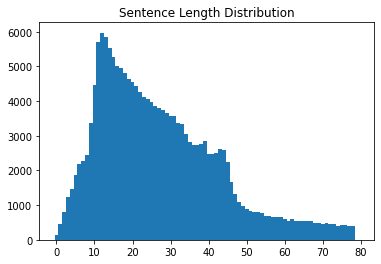

In [20]:
max_len = 80   
min_len = 0
        
filtered_corpus = corpus[corpus['document'].str.len() < max_len]   

sentence_length = np.zeros((max_len), dtype=np.int)

for sen in filtered_corpus['document']:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [21]:
filtered_corpus.tail(10)

,id,document,label
199990,5465496,장르는 무협인데 내가 보기엔 코믹이던데 막장 평점 2점도 아깝다,0
199991,8965828,나치입장에서 본 영화가 갑자기 연속으로 나오네? 뭔일 있었나...,0
199992,2228930,태권도???,0
199993,417815,음 왜 봤을까? 예고편이 다 -,0
199994,4834376,개연성이 없어요.. 별루다...,0
199995,8963373,포켓 몬스터 짜가 ㅡㅡ;;,0
199996,3302770,쓰.레.기,0
199997,5458175,완전 사이코영화. 마지막은 더욱더 이 영화의질을 떨어트린다.,0
199998,6908648,왜난 재미없었지 ㅠㅠ 라따뚜이 보고나서 스머프 봐서 그런가 ㅋㅋ,0
199999,8548411,포풍저그가나가신다영차영차영차,0


In [22]:
sentence_length

array([ 124,  460,  793, 1222, 1469, 1882, 2187, 2270, 2440, 3379, 4459,
       5711, 5970, 5848, 5518, 5265, 5005, 4947, 4806, 4626, 4542, 4436,
       4264, 4129, 4073, 3973, 3865, 3809, 3743, 3665, 3561, 3566, 3353,
       3339, 3036, 2831, 2736, 2736, 2775, 2856, 2486, 2486, 2495, 2625,
       2599, 2257, 1660, 1311, 1079,  968,  893,  844,  799,  789,  765,
        678,  686,  654,  658,  648,  614,  554,  600,  555,  544,  554,
        528,  528,  473,  493,  443,  477,  469,  443,  403,  437,  422,
        388,  398,    0])

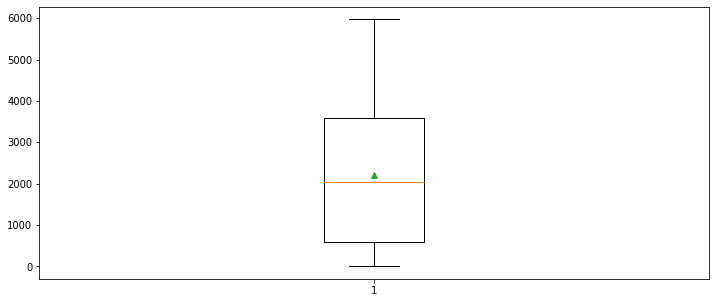

In [23]:
plt.figure(figsize=(12,5))
plt.boxplot([sentence_length], showmeans=True)
plt.show()

In [24]:
print('전처리 전 데이터 개수 :', raw_len)
print('전처리 후 데이터 개수 :', len(filtered_corpus))
print('전처리 후 남은 데이터 양(%)', (len(filtered_corpus)/raw_len)*100)

전처리 전 데이터 개수 : 200000
전처리 후 데이터 개수 : 176372
전처리 후 남은 데이터 양(%) 88.18599999999999


길이는 80으로 결정했습니다.

## 형태소 기반 토큰화
---

In [25]:
mecab = Mecab()

def mecab_split(sentence):
    return mecab.morphs(sentence)

def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [26]:
print(mecab.morphs('아버지가방에들어가신다.'))

['아버지', '가', '방', '에', '들어가', '신다', '.']


In [27]:
mecab_corpus = []
    
for kor in filtered_corpus['document']:
    mecab_corpus.append(mecab_split(kor))

In [28]:
print(len(mecab_corpus))

print(mecab_corpus[0])

176372
['어릴', '때', '보', '고', '지금', '다시', '봐도', '재밌', '어요', 'ㅋㅋ']


In [29]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 51787


In [30]:
print(filtered_corpus['document'][110])

# print (filtered_corpus.loc[filtered_corpus['document'].str.contains('허정무')])

print(mecab_corpus[100])

좀 짱인듯 허정무대신 장외룡감독을 한국국대로 고고싱
['좀', '짱', '인', '듯', '허정무', '대신', '장외룡', '감독', '을', '한국', '국', '대로', '고고', '싱']


In [31]:
texts = mecab_tokenizer.sequences_to_texts([mecab_tensor[100]])
print(texts[0])

좀 짱 인 듯 허정무 대신 장외룡 감독 을 한국 국 대로 고고 싱


## SentencePiece 모델 학습
---

In [32]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus['document']:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_unigram_4k --vocab_size={}'.format(temp_file, 4000)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_unigram_8k --vocab_size={}'.format(temp_file, vocab_size)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_unigram_12k --vocab_size={}'.format(temp_file, 12000)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe_4k --model_type=bpe --vocab_size={}'.format(temp_file, 4000)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe_8k --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_bpe_12k --model_type=bpe --vocab_size={}'.format(temp_file, 12000)    
)

!ls -l korean_spm*

-rw-r--r-- 1 root root 446670 Dec  9 07:08 korean_spm_bpe_12k.model
-rw-r--r-- 1 root root 185887 Dec  9 07:08 korean_spm_bpe_12k.vocab
-rw-r--r-- 1 root root 296983 Dec  9 07:07 korean_spm_bpe_4k.model
-rw-r--r-- 1 root root  50204 Dec  9 07:07 korean_spm_bpe_4k.vocab
-rw-r--r-- 1 root root 370509 Dec  9 07:07 korean_spm_bpe_8k.model
-rw-r--r-- 1 root root 115730 Dec  9 07:07 korean_spm_bpe_8k.vocab
-rw-r--r-- 1 root root 375034 Dec  8 05:42 korean_spm.model
-rw-r--r-- 1 root root 454051 Dec  9 07:07 korean_spm_unigram_12k.model
-rw-r--r-- 1 root root 227059 Dec  9 07:07 korean_spm_unigram_12k.vocab
-rw-r--r-- 1 root root 298434 Dec  9 07:06 korean_spm_unigram_4k.model
-rw-r--r-- 1 root root  64338 Dec  9 07:06 korean_spm_unigram_4k.vocab
-rw-r--r-- 1 root root 375045 Dec  9 07:06 korean_spm_unigram_8k.model
-rw-r--r-- 1 root root 144412 Dec  9 07:06 korean_spm_unigram_8k.vocab
-rw-r--r-- 1 root root 144412 Dec  8 05:42 korean_spm.vocab


학습 결과 확인

In [33]:
vocab_list = pd.read_csv('korean_spm_unigram_8k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
print('subword의 개수 :', len(vocab_list))
vocab_list[:10]

subword의 개수 : 8000


,0,1
0,<unk>,0.00000
1,<s>,0.00000
2,</s>,0.00000
3,▁,-3.29221
4,.,-3.47849
5,..,-4.28223
6,이,-4.44348
7,▁영화,-4.45867
8,...,-4.51412
9,의,-4.72683


In [34]:
vocab_list = pd.read_csv('korean_spm_bpe_12k.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)
print('subword의 개수 :', len(vocab_list))
vocab_list[:10]

subword의 개수 : 12000


,0,1
0,<unk>,0
1,<s>,0
2,</s>,0
3,..,0
4,영화,-1
5,▁영화,-2
6,▁이,-3
7,...,-4
8,▁아,-5
9,▁재,-6


### SentencePiece 모델 비교
---

In [35]:
def show_SP_demo(model):
    s = spm.SentencePieceProcessor()
    s.Load(model)

    # SentencePiece를 활용한 sentence -> encoding
    tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
    print(tokensIDs)

    # SentencePiece를 활용한 sentence -> encoded pieces
    print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

    # SentencePiece를 활용한 encoding -> sentence 복원
    print(s.DecodeIds(tokensIDs))

In [36]:
print('korean_spm_bpe_4k.model')
show_SP_demo(model='korean_spm_bpe_4k.model')
print()
print('korean_spm_bpe_8k.model')
show_SP_demo(model='korean_spm_bpe_8k.model')
print()
print('korean_spm_bpe_12k.model')
show_SP_demo(model='korean_spm_bpe_12k.model')
print()
print('korean_spm_unigram_4k.model')
show_SP_demo(model='korean_spm_unigram_4k.model')
print()
print('korean_spm_unigram_8k.model')
show_SP_demo(model='korean_spm_unigram_8k.model')
print()
print('korean_spm_unigram_12k.model')
show_SP_demo(model='korean_spm_unigram_12k.model')
print()
print('KoNLPy MeCab')
print(mecab.morphs('아버지가방에들어가신다.'))


korean_spm_bpe_4k.model
[8, 2447, 924, 2543, 2273, 1502, 2269, 2376, 2263, 2261]
['▁아', '버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.

korean_spm_bpe_8k.model
[5574, 924, 6543, 6273, 1502, 6269, 6376, 6263, 6261]
['▁아버', '지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.

korean_spm_bpe_12k.model
[8429, 10543, 10273, 1502, 10269, 10376, 10263, 10261]
['▁아버지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.

korean_spm_unigram_4k.model
[2035, 8, 391, 15, 1646, 8, 119, 13, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.

korean_spm_unigram_8k.model
[1600, 10, 424, 15, 1406, 10, 140, 16, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.

korean_spm_unigram_12k.model
[8506, 471, 15, 1649, 10, 177, 17, 3]
['▁아버지가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.

KoNLPy MeCab
['아버지', '가', '방', '에', '들어가', '신다', '.']


unigram 4k, unigram 8k, KoNLPy MeCab 모델에서 '아버지' 조사 '가' 적절히 구분한 것으로 판단된다.

## Tokenizer 함수 작성
---

In [37]:
def sp_tokenize(s, corpus, spm):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./{}.vocab".format(spm), 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({idx:word})
        index_word.update({word:idx})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=max_len)

    return tensor, word_index, index_word

In [38]:
# sp_tokenize(s, corpus) 사용 예제

s = spm.SentencePieceProcessor()

s.Load('korean_spm_unigram_8k.model') 

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus, 'korean_spm_unigram_8k')           
print(tensor)
# print(word_index)
# print(index_word)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0  544 3456   14 1246 1802    4]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1662 2221  241  566   10    3   17 7939  670    8]]


### lstm감정분석 모델 학습
---

In [39]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus['document'], 'korean_spm_unigram_8k')

In [40]:
# mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)
# mecab_tensor
mecab_word_index = mecab_tokenizer.index_word
mecab_index_word = mecab_tokenizer.word_index

데이터셋 나누기

In [41]:
filtered_label = np.array(filtered_corpus['label'])
x_train, x_val, y_train, y_val = train_test_split(tensor, filtered_label, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)

In [42]:
mx_train, mx_val, my_train, my_val = train_test_split(mecab_tensor, filtered_label, test_size=0.2)
mx_train, mx_test, my_train, my_test = train_test_split(mx_train, my_train, test_size=0.2)

In [43]:
x_train[111000]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,   49, 3985,   16,
       1681,  542, 7149], dtype=int32)

In [44]:
mx_train[111000]

array([ 4722, 18074,    66,    10,   120,   541,   283,    28,   166,
          18,  1873,  3298,     5,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0], dtype=int32)

In [45]:
print(len(x_train), len(x_test), len(x_val))
print(len(y_train), len(y_test), len(y_val))

112877 28220 35275
112877 28220 35275


In [46]:
print(len(mx_train), len(mx_test), len(mx_val))
print(len(my_train), len(my_test), len(my_val))

112877 28220 35275
112877 28220 35275


In [47]:

def make_LSTM_model(dim, layer, vocab):
    vocab_size = vocab
    word_vector_dim = dim 

    model_LSTM = keras.Sequential()
    model_LSTM.add(keras.layers.Embedding(vocab, 
                                 dim,
                                    ))
            
    model_LSTM.add(keras.layers.LSTM(layer))
    model_LSTM.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

    model_LSTM.summary()
    return model_LSTM

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

def train_LSTM_model(model_LSTM, epochs, batch_size, x_train, y_train, x_val, y_val):
    model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])              

    history_LSTM = model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=es,
                    verbose=1)
    
    return history_LSTM, model_LSTM

def show_result(model_LSTM, x_test, y_test):
    results = model_LSTM.evaluate(x_test,  y_test, verbose=2)
    return results


유니그램8k 모델

In [48]:
model_unigram8k=make_LSTM_model(32, 128, 8000)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          256000    
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [49]:
history_unigram8k, model_unigram8k = train_LSTM_model(model_unigram8k,20, 64, x_train, y_train, x_val, y_val)

Epoch 1/20
1764/1764 [==============================] - 38s 20ms/step - loss: 0.4683 - accuracy: 0.7650 - val_loss: 0.3486 - val_accuracy: 0.8465
Epoch 2/20
1764/1764 [==============================] - 35s 20ms/step - loss: 0.3117 - accuracy: 0.8652 - val_loss: 0.3312 - val_accuracy: 0.8546
Epoch 3/20
1764/1764 [==============================] - 35s 20ms/step - loss: 0.2691 - accuracy: 0.8846 - val_loss: 0.3383 - val_accuracy: 0.8540
Epoch 4/20
1764/1764 [==============================] - 35s 20ms/step - loss: 0.2385 - accuracy: 0.9015 - val_loss: 0.3443 - val_accuracy: 0.8510
Epoch 5/20
1764/1764 [==============================] - 35s 20ms/step - loss: 0.2075 - accuracy: 0.9134 - val_loss: 0.3614 - val_accuracy: 0.8517
Epoch 6/20
1764/1764 [==============================] - 35s 20ms/step - loss: 0.1792 - accuracy: 0.9279 - val_loss: 0.4137 - val_accuracy: 0.8433
Epoch 00006: early stopping


In [50]:
print(show_result(model_unigram8k, x_test, y_test))

882/882 - 5s - loss: 0.4190 - accuracy: 0.8395
[0.4189665615558624, 0.8395464420318604]


konlpy 모델

In [51]:
model_mecab=make_LSTM_model(32, 128, 60000)
# 8000이라고 했더니 오류가 발생해서 mecab으로 확인한 51787의 vocabsize를 참조해 60000으로 바꿔줬습니다.

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          1920000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,002,561
Trainable params: 2,002,561
Non-trainable params: 0
_________________________________________________________________


In [52]:
history_mecab, model_mecab = train_LSTM_model(model_mecab, 20, 64, mx_train, my_train, mx_val, my_val)

Epoch 1/20
1764/1764 [==============================] - 41s 22ms/step - loss: 0.6778 - accuracy: 0.5570 - val_loss: 0.6738 - val_accuracy: 0.5904
Epoch 2/20
1764/1764 [==============================] - 39s 22ms/step - loss: 0.6696 - accuracy: 0.5951 - val_loss: 0.6817 - val_accuracy: 0.5592
Epoch 3/20
1764/1764 [==============================] - 39s 22ms/step - loss: 0.6849 - accuracy: 0.5407 - val_loss: 0.6747 - val_accuracy: 0.5936
Epoch 4/20
1764/1764 [==============================] - 39s 22ms/step - loss: 0.6709 - accuracy: 0.5995 - val_loss: 0.6585 - val_accuracy: 0.6145
Epoch 5/20
1764/1764 [==============================] - 38s 22ms/step - loss: 0.5111 - accuracy: 0.7402 - val_loss: 0.3876 - val_accuracy: 0.8255
Epoch 6/20
1764/1764 [==============================] - 39s 22ms/step - loss: 0.3159 - accuracy: 0.8677 - val_loss: 0.3776 - val_accuracy: 0.8353
Epoch 7/20
1764/1764 [==============================] - 39s 22ms/step - loss: 0.2511 - accuracy: 0.9017 - val_loss: 0.4119 -

In [53]:
print(show_result(model_mecab, mx_test, my_test))

882/882 - 4s - loss: 0.5083 - accuracy: 0.8190
[0.5083483457565308, 0.8189936280250549]


나머지 모델 데이터 셋 마련

In [54]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus['document'], 'korean_spm_unigram_4k')

In [55]:
u4kx_train, u4kx_val, u4ky_train, u4ky_val = train_test_split(tensor, filtered_label, test_size=0.2)
u4kx_train, u4kx_test, u4ky_train, u4ky_test = train_test_split(x_train, y_train, test_size=0.2)

In [56]:
print(len(u4kx_train), len(u4kx_test), len(u4kx_val))
print(len(u4ky_train), len(u4ky_test), len(u4ky_val))

90301 22576 35275
90301 22576 35275


In [57]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus['document'], 'korean_spm_unigram_12k')

In [58]:
u12kx_train, u12kx_val, u12ky_train, u12ky_val = train_test_split(tensor, filtered_label, test_size=0.2)
u12kx_train, u12kx_test, u12ky_train, u12ky_test = train_test_split(x_train, y_train, test_size=0.2)

In [59]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus['document'], 'korean_spm_bpe_4k')

In [60]:
b4kx_train, b4kx_val, b4ky_train, b4ky_val = train_test_split(tensor, filtered_label, test_size=0.2)
b4kx_train, b4kx_test, b4ky_train, b4ky_test = train_test_split(x_train, y_train, test_size=0.2)

In [61]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus['document'], 'korean_spm_bpe_8k')

In [62]:
b8kx_train, b8kx_val, b8ky_train, b8ky_val = train_test_split(tensor, filtered_label, test_size=0.2)
b8kx_train, b8kx_test, b8ky_train, b8ky_test = train_test_split(x_train, y_train, test_size=0.2)

In [63]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus['document'], 'korean_spm_bpe_12k')

In [64]:
b12kx_train, b12kx_val, b12ky_train, b12ky_val = train_test_split(tensor, filtered_label, test_size=0.2)
b12kx_train, b12kx_test, b12ky_train, b12ky_test = train_test_split(x_train, y_train, test_size=0.2)

unigram4k model

In [65]:
model_unigram4k=make_LSTM_model(32, 128, 8000)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          256000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [66]:
history_unigram4k, model_unigram4k = train_LSTM_model(model_unigram4k,20, 64, u4kx_train, u4ky_train, u4kx_val, u4ky_val)

Epoch 1/20
1411/1411 [==============================] - 30s 20ms/step - loss: 0.4854 - accuracy: 0.7543 - val_loss: 0.3349 - val_accuracy: 0.8564
Epoch 2/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.3202 - accuracy: 0.8637 - val_loss: 0.3078 - val_accuracy: 0.8701
Epoch 3/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2739 - accuracy: 0.8832 - val_loss: 0.2898 - val_accuracy: 0.8789
Epoch 4/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2354 - accuracy: 0.9037 - val_loss: 0.2828 - val_accuracy: 0.8831
Epoch 5/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2067 - accuracy: 0.9169 - val_loss: 0.2785 - val_accuracy: 0.8914
Epoch 6/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.1732 - accuracy: 0.9316 - val_loss: 0.2787 - val_accuracy: 0.8956
Epoch 7/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.1472 - accuracy: 0.9427 - val_loss: 0.2914 -

In [67]:
print(show_result(model_unigram4k, u4kx_test, u4ky_test))

706/706 - 4s - loss: 0.6188 - accuracy: 0.8306
[0.618834912776947, 0.8305723071098328]


bpe4k model

In [68]:
model_bpe4k=make_LSTM_model(32, 128, 8000)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          256000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [69]:
history_bpe4k, model_bpe4k = train_LSTM_model(model_bpe4k,20, 64, b4kx_train, b4ky_train, b4kx_val, b4ky_val)

Epoch 1/20
1411/1411 [==============================] - 30s 20ms/step - loss: 0.4766 - accuracy: 0.7594 - val_loss: 0.3285 - val_accuracy: 0.8589
Epoch 2/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.3112 - accuracy: 0.8680 - val_loss: 0.2997 - val_accuracy: 0.8740
Epoch 3/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2658 - accuracy: 0.8894 - val_loss: 0.2835 - val_accuracy: 0.8802
Epoch 4/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2339 - accuracy: 0.9019 - val_loss: 0.2772 - val_accuracy: 0.8874
Epoch 5/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2028 - accuracy: 0.9163 - val_loss: 0.2720 - val_accuracy: 0.8922
Epoch 6/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.1702 - accuracy: 0.9313 - val_loss: 0.2893 - val_accuracy: 0.8934
Epoch 7/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.1401 - accuracy: 0.9436 - val_loss: 0.2847 -

In [70]:
print(show_result(model_unigram4k, b4kx_test, b4ky_test))

706/706 - 4s - loss: 0.1877 - accuracy: 0.9449
[0.18771037459373474, 0.944941520690918]


unigram12k model

In [71]:
model_unigram12k=make_LSTM_model(32, 128, 8000)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          256000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [72]:
history_unigram12k, model_unigram12k = train_LSTM_model(model_unigram12k, 20, 64, u12kx_train, u12ky_train, u12kx_val, u12ky_val)

Epoch 1/20
1411/1411 [==============================] - 31s 20ms/step - loss: 0.4969 - accuracy: 0.7468 - val_loss: 0.3279 - val_accuracy: 0.8593
Epoch 2/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.3152 - accuracy: 0.8662 - val_loss: 0.2991 - val_accuracy: 0.8729
Epoch 3/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2749 - accuracy: 0.8842 - val_loss: 0.2869 - val_accuracy: 0.8795
Epoch 4/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2358 - accuracy: 0.9017 - val_loss: 0.2785 - val_accuracy: 0.8860
Epoch 5/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2017 - accuracy: 0.9166 - val_loss: 0.2704 - val_accuracy: 0.8926
Epoch 6/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.1694 - accuracy: 0.9317 - val_loss: 0.2834 - val_accuracy: 0.8962
Epoch 7/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.1441 - accuracy: 0.9428 - val_loss: 0.2884 -

In [73]:
print(show_result(model_unigram12k, u12kx_test, u12ky_test))

706/706 - 4s - loss: 0.6119 - accuracy: 0.8244
[0.6119276285171509, 0.8244153261184692]


bpe8k model

In [74]:
model_bpe8k=make_LSTM_model(32, 128, 8000)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          256000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [75]:
history_bpe8k, model_bpe8k = train_LSTM_model(model_bpe8k,20, 64, b8kx_train, b8ky_train, b8kx_val, b8ky_val)

Epoch 1/20
1411/1411 [==============================] - 30s 20ms/step - loss: 0.4861 - accuracy: 0.7517 - val_loss: 0.3321 - val_accuracy: 0.8580
Epoch 2/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.3141 - accuracy: 0.8660 - val_loss: 0.3060 - val_accuracy: 0.8713
Epoch 3/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2753 - accuracy: 0.8839 - val_loss: 0.2923 - val_accuracy: 0.8800
Epoch 4/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2366 - accuracy: 0.9027 - val_loss: 0.2767 - val_accuracy: 0.8858
Epoch 5/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2078 - accuracy: 0.9152 - val_loss: 0.2734 - val_accuracy: 0.8911
Epoch 6/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.1741 - accuracy: 0.9308 - val_loss: 0.2742 - val_accuracy: 0.8958
Epoch 7/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.1481 - accuracy: 0.9417 - val_loss: 0.2853 -

In [76]:
print(show_result(model_bpe8k, b8kx_test, b8ky_test))

706/706 - 4s - loss: 0.5940 - accuracy: 0.8310
[0.5940221548080444, 0.8309709429740906]


bpe12k model

In [77]:
model_bpe12k=make_LSTM_model(32, 128, 8000)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          256000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               82432     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 338,561
Trainable params: 338,561
Non-trainable params: 0
_________________________________________________________________


In [78]:
history_bpe12k, model_bpe12k = train_LSTM_model(model_bpe12k, 20, 64, b12kx_train, b12ky_train, b12kx_val, b12ky_val)

Epoch 1/20
1411/1411 [==============================] - 30s 20ms/step - loss: 0.4766 - accuracy: 0.7579 - val_loss: 0.3304 - val_accuracy: 0.8573
Epoch 2/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.3117 - accuracy: 0.8683 - val_loss: 0.3066 - val_accuracy: 0.8694
Epoch 3/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2705 - accuracy: 0.8852 - val_loss: 0.2867 - val_accuracy: 0.8803
Epoch 4/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2384 - accuracy: 0.8998 - val_loss: 0.2782 - val_accuracy: 0.8869
Epoch 5/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.2059 - accuracy: 0.9156 - val_loss: 0.2742 - val_accuracy: 0.8916
Epoch 6/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.1739 - accuracy: 0.9294 - val_loss: 0.2761 - val_accuracy: 0.8958
Epoch 7/20
1411/1411 [==============================] - 28s 20ms/step - loss: 0.1448 - accuracy: 0.9435 - val_loss: 0.3040 -

In [79]:
print(show_result(model_bpe12k, b12kx_test, b12ky_test))

706/706 - 4s - loss: 0.5808 - accuracy: 0.8253
[0.5808307528495789, 0.825256884098053]


### 학습과정 시각화
---

In [80]:
def draw_graph(model_history, param):
    # summarize history for accuracy
    plt.plot(model_history.history['accuracy'])
    plt.plot(model_history.history['val_accuracy'])
    plt.title('{}_accuracy'.format(param))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.title('{}_loss'.format(param))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

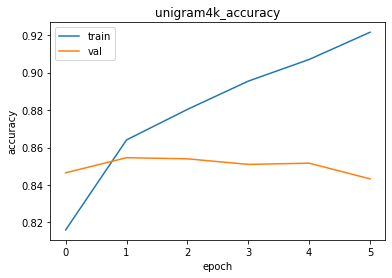

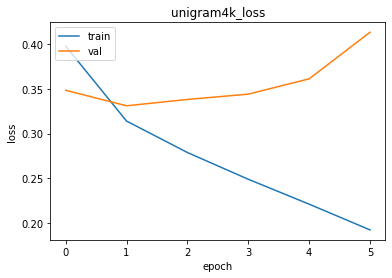

In [81]:
draw_graph(history_unigram8k, 'unigram4k')

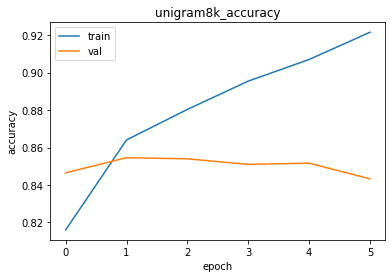

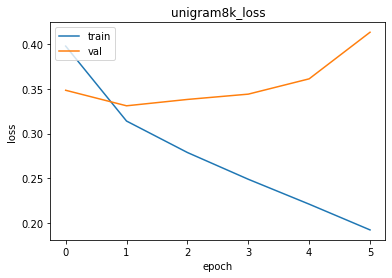

In [82]:
draw_graph(history_unigram8k, 'unigram8k')

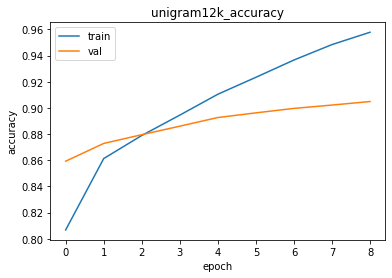

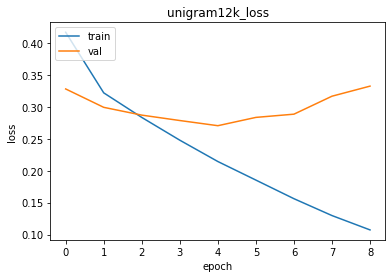

In [83]:
draw_graph(history_unigram12k, 'unigram12k')

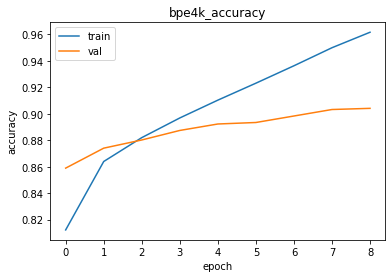

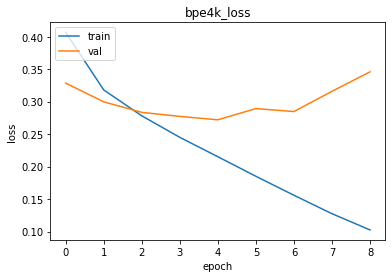

In [84]:
draw_graph(history_bpe4k, 'bpe4k')

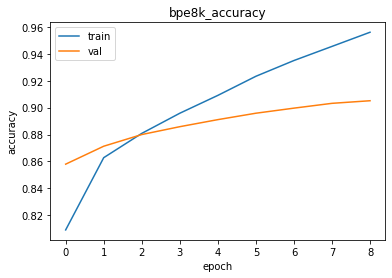

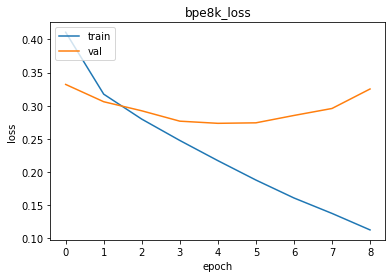

In [85]:
draw_graph(history_bpe8k, 'bpe8k')

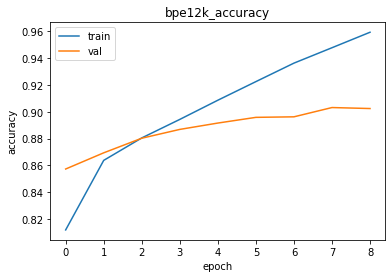

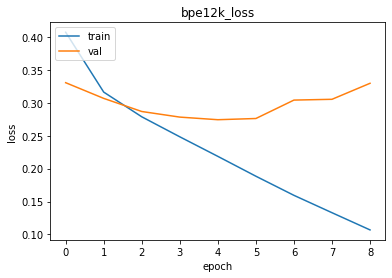

In [86]:
draw_graph(history_bpe12k, 'bpe12k')

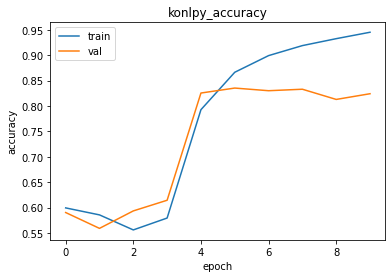

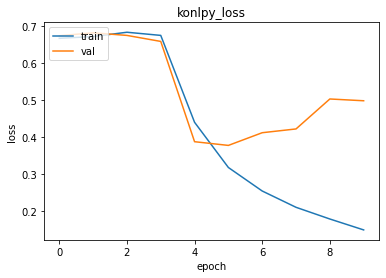

In [87]:
draw_graph(history_mecab, 'konlpy')


### 결과
---
학습한 모든 모델이 test accuracy에서 80%이상의 성능을 보였으며, vocab_size를 4000으로한 bpe를 적용한 모델의 경우 0.9를 상회하는 test accuracy를 얻을 수 있었습니다. 

학습 결과에서 konlpy만 다소 특이한 변화를 보였습니다만,\
노드의 코드가 너무 단순하고, 텐서의 모양을 바꾸는 등의 설정방식을 파악 못 했기에,\
제대로 되지 못 한 적용일 수도 있겠다는 생각이 듭니다.

unigram과 나머지 bpe는 별 다른 차이를 보이지 못 했으며, konlpy도 비슷한 정확도에서 마무리되었습니다.



### 회고
---
지나온 node인 영화감성분석의 lstm 모델을 구성하는데있어서 많은 부족함을 느꼈습니다.\
노드가 끝나도록 이해가 안 되는 부분 중에 하나는 모델에 입력하는 vocab_size가 전처리에서의 vocab_size와 무관하게 8000으로\
모두 작동이 되는 점이었습니다.

4k나 12k에 맞게 값을 바꿔주는 시도를 했는데, 값을 줄일시 에러가 발생해서 8000으로 진행했으며, 12000의 경우에도 8000으로 작동되기에\
모델에 대한 추가공부의 중요성을 느낄 수 있었습니다.
